In [1]:
import threading
import numpy as np
import tensorflow as tf
import pylab
import time
import gym
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
# global variables for threading
episode = 0
scores = []

EPISODES = 2000

In [3]:
# This is A3C(Asynchronous Advantage Actor Critic) agent(global) for the Cartpole
# In this example, we use A3C algorithm
class A3CAgent:
    def __init__(self, state_size, action_size, env_name):
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # get gym environment name
        self.env_name = env_name

        # these are hyper parameters for the A3C
        self.actor_lr = 0.001
        self.critic_lr = 0.001
        self.discount_factor = .99
        self.hidden1, self.hidden2 = 24, 24
        self.threads = 8

        # create model for actor and critic network
        self.actor, self.critic = self.build_model()

        # method for training actor and critic network
        self.optimizer = [self.actor_optimizer(), self.critic_optimizer()]

        self.sess = tf.InteractiveSession()
        K.set_session(self.sess)
        self.sess.run(tf.global_variables_initializer())

    # approximate policy and value using Neural Network
    # actor -> state is input and probability of each action is output of network
    # critic -> state is input and value of state is output of network
    # actor and critic network share first hidden layer
    def build_model(self):
        state = Input(batch_shape=(None,  self.state_size))
        shared = Dense(self.hidden1, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_uniform')(state)

        actor_hidden = Dense(self.hidden2, activation='relu', kernel_initializer='glorot_uniform')(shared)
        action_prob = Dense(self.action_size, activation='softmax', kernel_initializer='glorot_uniform')(actor_hidden)

        value_hidden = Dense(self.hidden2, activation='relu', kernel_initializer='he_uniform')(shared)
        state_value = Dense(1, activation='linear', kernel_initializer='he_uniform')(value_hidden)

        actor = Model(inputs=state, outputs=action_prob)
        critic = Model(inputs=state, outputs=state_value)

        actor._make_predict_function()
        critic._make_predict_function()

        actor.summary()
        critic.summary()

        return actor, critic

    # make loss function for Policy Gradient
    # [log(action probability) * advantages] will be input for the back prop
    # we add entropy of action probability to loss
    def actor_optimizer(self):
        action = K.placeholder(shape=(None, self.action_size))
        advantages = K.placeholder(shape=(None, ))

        policy = self.actor.output

        good_prob = K.sum(action * policy, axis=1)
        eligibility = K.log(good_prob + 1e-10) * K.stop_gradient(advantages)
        loss = -K.sum(eligibility)

        entropy = K.sum(policy * K.log(policy + 1e-10), axis=1)

        #actor_loss = loss + 0.01*entropy
        actor_loss = loss


        optimizer = Adam(lr=self.actor_lr)
        updates = optimizer.get_updates(self.actor.trainable_weights, [], actor_loss)
        train = K.function([self.actor.input, action, advantages], [], updates=updates)
        return train

    # make loss function for Value approximation
    def critic_optimizer(self):
        discounted_reward = K.placeholder(shape=(None, ))

        value = self.critic.output

        loss = K.mean(K.square(discounted_reward - value))

        optimizer = Adam(lr=self.critic_lr)
        updates = optimizer.get_updates(self.critic.trainable_weights, [], loss)
        train = K.function([self.critic.input, discounted_reward], [], updates=updates)
        return train

    # make agents(local) and start training
    def train(self):
        # self.load_model('./save_model/cartpole_a3c.h5')
        agents = [Agent(i, self.actor, self.critic, self.optimizer, self.env_name, self.discount_factor,
                        self.action_size, self.state_size) for i in range(self.threads)]

        for agent in agents:
            agent.start()

        while True:
            time.sleep(20)

            plot = scores[:]
            pylab.plot(range(len(plot)), plot, 'b')
            pylab.savefig("./save_graph/cartpole_a3c.png")

            self.save_model('./save_model/cartpole_a3c.h5')

    def save_model(self, name):
        self.actor.save_weights(name + "_actor.h5")
        self.critic.save_weights(name + "_critic.h5")

    def load_model(self, name):
        self.actor.load_weights(name + "_actor.h5")
        self.critic.load_weights(name + "_critic.h5")

In [4]:
# This is Agent(local) class for threading
class Agent(threading.Thread):
    def __init__(self, index, actor, critic, optimizer, env_name, discount_factor, action_size, state_size):
        threading.Thread.__init__(self)

        self.states = []
        self.rewards = []
        self.actions = []

        self.index = index
        self.actor = actor
        self.critic = critic
        self.optimizer = optimizer
        self.env_name = env_name
        self.discount_factor = discount_factor
        self.action_size = action_size
        self.state_size = state_size

    # Thread interactive with environment
    def run(self):
        global episode
        env = gym.make(self.env_name)
        while episode < EPISODES:
            state = env.reset()
            score = 0
            while True:
                action = self.get_action(state)
                next_state, reward, done, _ = env.step(action)
                score += reward

                self.memory(state, action, reward)

                state = next_state

                if done:
                    episode += 1
                    print("episode: ", episode, "/ score : ", score)
                    scores.append(score)
                    self.train_episode(score != 500)
                    break

    # In Policy Gradient, Q function is not available.
    # Instead agent uses sample returns for evaluating policy
    def discount_rewards(self, rewards, done=True):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        if not done:
            running_add = self.critic.predict(np.reshape(self.states[-1], (1, self.state_size)))[0]
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    # save <s, a ,r> of each step
    # this is used for calculating discounted rewards
    def memory(self, state, action, reward):
        self.states.append(state)
        act = np.zeros(self.action_size)
        act[action] = 1
        self.actions.append(act)
        self.rewards.append(reward)

    # update policy network and value network every episode
    def train_episode(self, done):
        discounted_rewards = self.discount_rewards(self.rewards, done)

        values = self.critic.predict(np.array(self.states))
        values = np.reshape(values, len(values))

        advantages = discounted_rewards - values

        self.optimizer[0]([self.states, self.actions, advantages])
        self.optimizer[1]([self.states, discounted_rewards])
        self.states, self.actions, self.rewards = [], [], []

    def get_action(self, state):
        policy = self.actor.predict(np.reshape(state, [1, self.state_size]))[0]
        return np.random.choice(self.action_size, 1, p=policy)[0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Den

FileNotFoundError: [Errno 2] No such file or directory: './save_graph/cartpole_a3c.png'

episode:  294 / score :  217.0


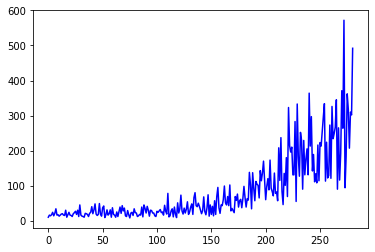

episode:  295 / score :  442.0
episode:  296 / score :  431.0
episode:  297 / score :  385.0
episode:  298 / score :  376.0
episode:  299 / score :  482.0
episode:  300 / score :  120.0
episode:  301 / score :  319.0
episode:  302 / score :  159.0
episode:  303 / score :  111.0
episode:  304 / score :  164.0
episode:  305 / score :  819.0
episode:  306 / score :  555.0
episode:  307 / score :  272.0
episode:  308 / score :  811.0
episode:  309 / score :  724.0
episode:  310 / score :  351.0
episode:  311 / score :  210.0
episode:  312 / score :  654.0
episode:  313 / score :  162.0
episode:  314 / score :  298.0
episode: episode:  315 / score :  281.0
 316 / score :  284.0
episode:  317 / score :  106.0
episode:  318 / score :  193.0
episode:  319 / score :  281.0
episode:  320 / score :  212.0
episode:  episode: 321 / score :  141.0
 322 / score :  216.0
episode:  323 / score :  169.0
episode:  324 / score :  245.0
episode:  325 / score :  241.0
episode:  326 / score :  143.0
episode:

In [5]:
if __name__ == "__main__":
    env_name = 'CartPole-v1'
    env = gym.make(env_name)

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    env.close()

    global_agent = A3CAgent(state_size, action_size, env_name)
    global_agent.train()